In [411]:
# --- TASK 1: DATA DOWNLOAD ---

In [1]:
# Loading packages

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

In [2]:
# Date range

end_date = datetime.now()
start_date = end_date - timedelta(days = 7)

In [3]:
# API endpoint and parameters

url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"
params = {
    "$where": "created_date between '{}' and '{}' and agency = 'HPD'".format(start_date.isoformat(), end_date.isoformat()),
    "$limit": 10000000 # high limit to prevent incomplete data retrieval
}

In [4]:
# Make the API request, convert JSON to DataFrame, and save to a csv file

response = requests.get(url, params = params)
data = response.json()

raw_data = pd.DataFrame(data)

output_path = os.path.join('data','raw.csv')

raw_data.to_csv(output_path, index = False)

hpd_data = raw_data.copy() # working with a copy of the raw data so not to corrupt the original source

In [416]:
# --- TASK 2: DATA AGGREGATION ---

In [5]:
# Converting the 'created_date' to datetime format and creating a new column create_date_hour that formats the year, month, day, and hour

hpd_data['created_date'] = pd.to_datetime(hpd_data['created_date'])
hpd_data['created_date_hour'] = hpd_data['created_date'].dt.strftime('%Y-%m-%d %H:00:00')
hpd_data['created_date_hour'] = pd.to_datetime(hpd_data['created_date_hour'])

# Grouping by created_date_hour and complaint_type and counting occurences

aggregated_data = hpd_data.groupby(['created_date_hour', 'complaint_type']).size().reset_index(name = 'count')

In [6]:
# Exporting to csv

aggregated_output_path = '/Users/florencebogitsh/Desktop/Jake/Projects/DCP/Associate_GIS_Specialist/data/aggregated_data.csv'
aggregated_data.to_csv(aggregated_output_path, index = False)

In [419]:
# --- TASK 3: DATA VISUALIZATION ---

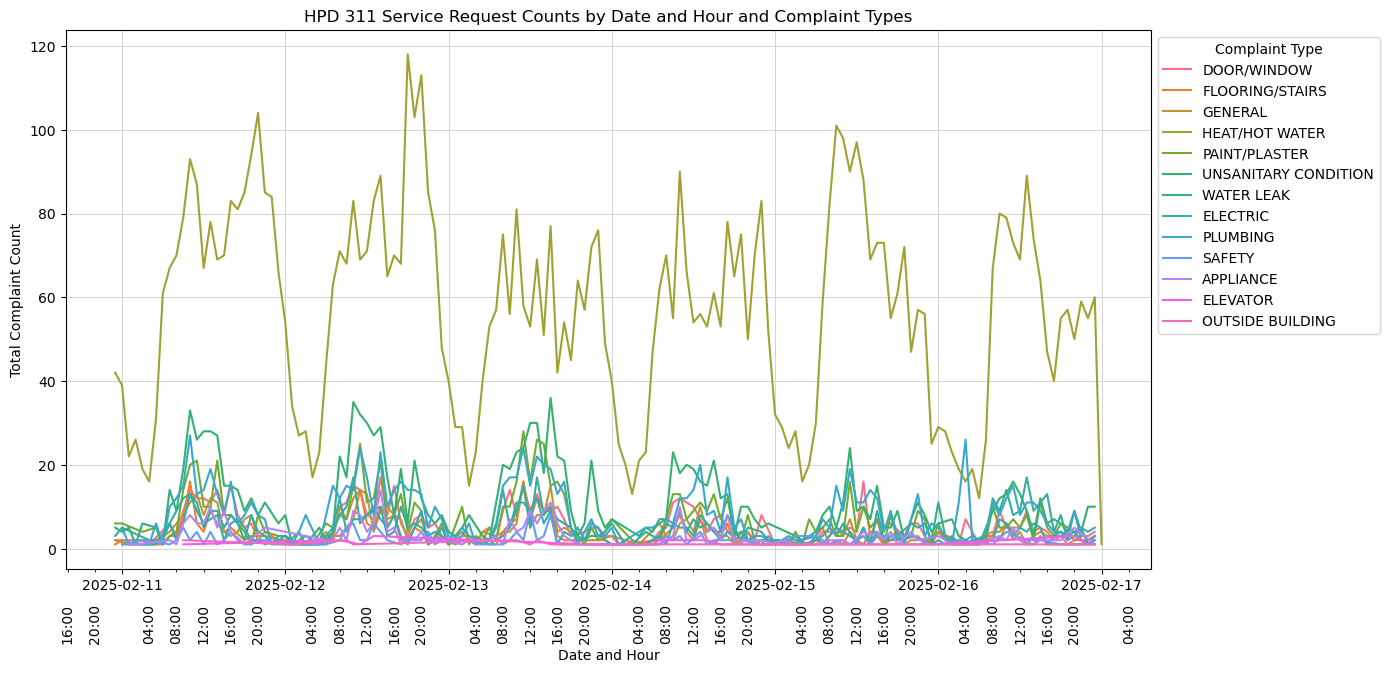

In [7]:
# Create a multi-line plot 
plt.figure(figsize = (14, 7)) 
sns.lineplot(
    data = aggregated_data, 
    x = 'created_date_hour', 
    y = 'count', 
    hue = 'complaint_type'
)

# Adjust title, labels, and add a grid
plt.title('HPD 311 Service Request Counts by Date and Hour and Complaint Types')
plt.xlabel('Date and Hour')
plt.ylabel('Total Complaint Count')

# Adjust label orientation and add major gridlines
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=4)) # Display tick marks for every 4 hours
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(which='major', color='lightgray', linestyle='-', linewidth=0.7)

# Make minor tick labels visible
for label in plt.gca().get_xticklabels(minor = True):
    label.set_visible(True)
    if int(label.get_text()[-2:]) % 12 != 0: # Reduce the number of labels displayed
        label.set_visible(False)

# Rotate the visible minor tick labels by 90 degrees and adjust their vertical position
for label in plt.gca().get_xticklabels(minor=True):
    label.set_rotation(90)
    label.set_y(-0.05)

# Adjust legend
plt.legend(title = 'Complaint Type', loc = 'upper left', bbox_to_anchor = (1, 1))

# Save the plot
plot_path = 'data/hpd_311complaints_multilineplot_base.png' 
plt.savefig(plot_path, bbox_inches = 'tight')

In [8]:
# Creating a threshold to visualize top complaint types
highlight_threshold = 25
aggregated_data['highlight'] = aggregated_data['count'] > highlight_threshold

complaint_max_counts = aggregated_data.groupby('complaint_type')['count'].max().sort_values(ascending = False)

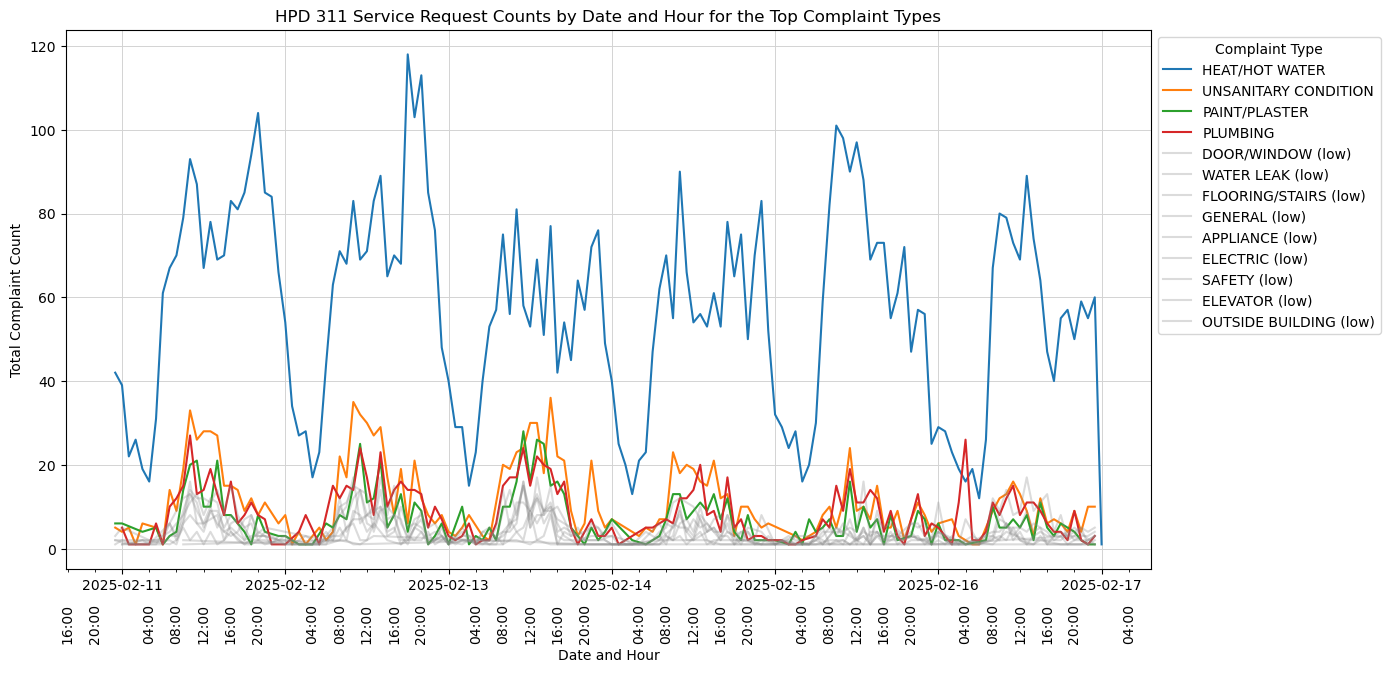

In [9]:
# Create a multi-line plot with distinction between high and low counts for better visualization
plt.figure(figsize = (14, 7)) 

# Define a colormap for different shades of gray
gray_cmap = sns.color_palette("Greys", n_colors=10)

# Plot values below the threshold with shades of gray and highlight values above the threshold with color
for complaint_type in complaint_max_counts.index:
    data = aggregated_data[aggregated_data['complaint_type'] == complaint_type]
    if data['count'].max() > highlight_threshold:
        # Highlight entire line if any segment exceeds the threshold
        sns.lineplot(data = data, x = 'created_date_hour', y = 'count', label = complaint_type)
    else:
        # Plot with shades of gray if none of the segments exceed the threshold
        sns.lineplot(data = data, x = 'created_date_hour', y = 'count', color = gray_cmap[5], alpha = 0.3, label = f'{complaint_type} (low)')

# Adjust title, labels, and grid
plt.title('HPD 311 Service Request Counts by Date and Hour for the Top Complaint Types')
plt.xlabel('Date and Hour')
plt.ylabel('Total Complaint Count')

# Adjust label orientation and add major gridlines
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval = 4)) # Display tick marks for every 4 hours
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(which = 'major', color = 'lightgray', linestyle = '-', linewidth = 0.7)

# Make minor tick labels visible
for label in plt.gca().get_xticklabels(minor = True):
    label.set_visible(True)
    if int(label.get_text()[-2:]) % 12 != 0: # Reduce the number of labels displayed
        label.set_visible(False)

# Rotate the visible minor tick labels by 90 degrees and adjust their vertical position
for label in plt.gca().get_xticklabels(minor = True):
    label.set_rotation(90)
    label.set_y(-0.05)

# Adjust legend
plt.legend(title = 'Complaint Type', loc = 'upper left', bbox_to_anchor = (1, 1))

# Save the plot
plot_path = 'data/hpd_311complaints_multilineplot_refined.png' 
plt.savefig(plot_path, bbox_inches = 'tight')

In [423]:
# --- TASK 4: SPATIAL DATA PROCESSING ---

In [10]:
# Loading the 2020 NTA boundaries

nta_2020 = gpd.read_file('/Users/florencebogitsh/Desktop/Jake/Data/Shapefile/NTA 2020/nynta2020.shp')
nta_2020 = nta_2020.to_crs(epsg = 4326) # Changing the coordinate reference system to WGS84 to match 311 data

In [11]:
# Convert the 311 HPD data to a GeoDataFrame

# Creating a new column called 'geometry' that aggregates the latitude and longitude columns
hpd_data['geometry'] = hpd_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1 )
hpd_gdf = gpd.GeoDataFrame(hpd_data, geometry = 'geometry', crs = 'EPSG:4326')

# Filtering for Heat and Hot Water
specific_complaint_type = 'HEAT/HOT WATER'

filtered_hpd_gdf = hpd_gdf[(hpd_gdf['created_date'] >= start_date) & (hpd_gdf['created_date'] <= end_date) 
                           & (hpd_gdf['complaint_type'] == specific_complaint_type)]

In [12]:
# Spatially joining HPD data with NTA boundaries

joined_gdf = gpd.sjoin(filtered_hpd_gdf, nta_2020, how = "left", predicate = "within")

In [13]:
# Aggregate data by NTA

nta_counts = joined_gdf.groupby('NTAName').size().reset_index(name = 'count')

# Join aggregated counts with NTA boundaries

nta_2020_count = nta_2020.merge(nta_counts, on = 'NTAName', how = 'left')
nta_2020_count['count'] = nta_2020_count['count'].fillna(0) # Handling NA values by converting to 0s

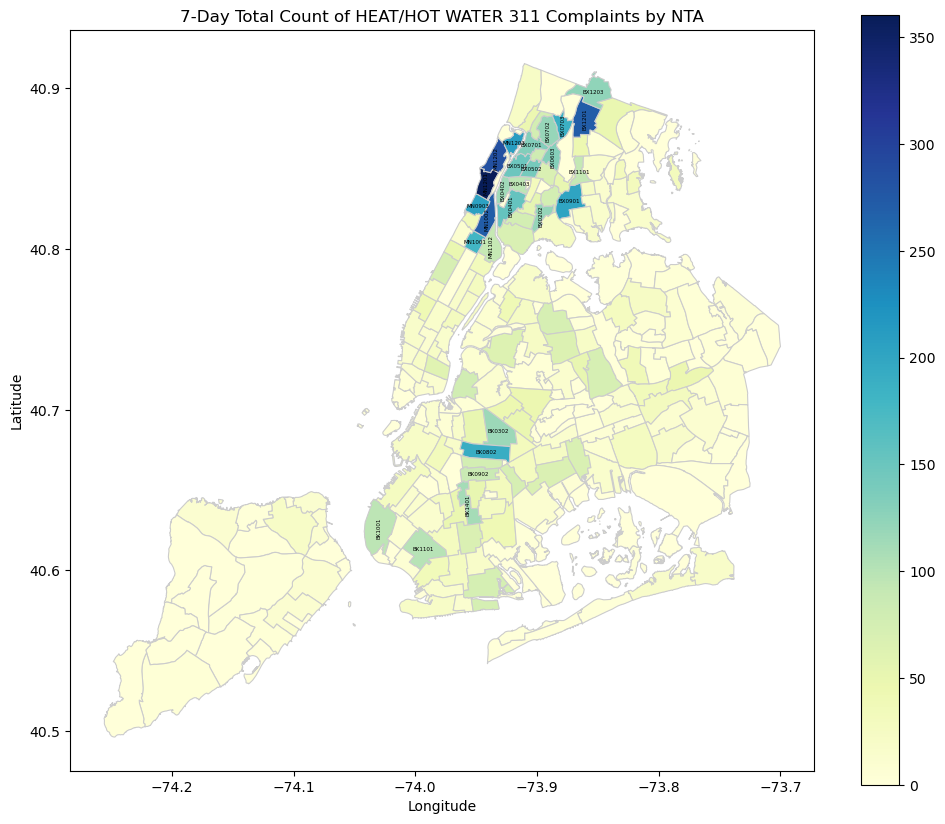

In [14]:
# Create the choropleth map

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
nta_2020_count.plot(column = 'count', cmap = 'YlGnBu', linewidth = 0.8, ax = ax, edgecolor = '0.8', legend = True)

# Customizing the plot
plt.title(f'7-Day Total Count of {specific_complaint_type} 311 Complaints by NTA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# High count threshold for the top 10% of counts
high_count_threshold = nta_2020_count['count'].quantile(0.90)

# Add labels for NTAs in the highest count range and adjust label orientation for the best fit inside polygons
for idx, row in nta_2020_count.iterrows():
    if row['count'] >= high_count_threshold:
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
        bbox = row['geometry'].bounds
        aspect_ratio = (bbox[3] - bbox[1]) / (bbox[2] - bbox[0])
        
        if aspect_ratio > 1:
            # Fit vertically if the polygon is taller than it is wide
            rotation = 'vertical'
            ha = 'center'
            va = 'center'
        else:
            # Fit horizontally if the polygon is wider than it is tall
            rotation = 'horizontal'
            ha = 'center'
            va = 'center'
        
        ax.text(x, y, row['NTA2020'], fontsize = 4, color = 'black', ha = ha, va = va, rotation = rotation, transform = ax.transData, clip_on = True)
        
# Save the plot
plot_path = 'data/hpd_heat_hotwater_complaints_7day_nta.png' 
plt.savefig(plot_path, bbox_inches = 'tight')